<a href="https://colab.research.google.com/github/GundetiManoj/MTP-Research-paper/blob/main/MTP_RESEARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Building a reproducible implementation of the DP quantum fault-tree encoding.
# This cell does three things:
# 1. Provides functions to build an equivalent Qiskit circuit (if Qiskit is installed).
# 2. Computes the *exact* (classical) top-event failure probability by enumerating all 2^9 basic-event states.
# 3. Falls back to a classical Monte-Carlo sampler (or Qiskit simulator if available) to estimate the top-event probability.
#
# The code is generic: you can replace the `basic_probs` dictionary with the exact basic-event probabilities from your source.
# By default I use the values from the printed Table 1 in the case study. If the table's exponents were lost in the PDF-to-text step,
# please edit the numbers in `basic_probs` to the correct values (they are clearly labeled there in the PDF).
#
# NOTE: This implementation *does not require* Qiskit to compute the final TOP failure probability exactly —
# the classical enumeration is deterministic and fast (2^9 = 512 states).
#
# If Qiskit is installed in the environment, the function `build_qiskit_circuit` will also create a Qiskit circuit that encodes the same
# probabilities using Ry gates and reversible logic for OR/AND (OR via De Morgan using X + multi-controlled X).
# If not present, the code still computes the exact probability and performs a Monte Carlo check.
#
# Run the cell to compute the exact TOP failure probability and (optionally) simulate the Qiskit circuit.

import math
import itertools
import numpy as np

# --- Edit these probabilities if you have the exact magnitudes from your Table 1 ---
# Keys: names for the 9 basic events
basic_probs = {
    # Computer R1 basic events
    "hw_R1": 2.44e-1,        # hardware error (example value, replace with correct exponent if needed)
    "sw_R1": 8.54e-2,        # software error
    "hum_R1": 5.68e-2,       # human error
    # Computer R2 basic events (assumed identical to R1 in paper)
    "hw_R2": 2.44e-1,
    "sw_R2": 8.54e-2,
    "hum_R2": 5.68e-2,
    # Power branch: power generation + two UPS units
    "power_gen": 3.41e-4,    # example magnitude (replace with exact)
    "ups1": 3.66e-4,
    "ups2": 3.66e-4,
}

# For convenience, get the list of event names in a consistent order (this will be our mapping to qubits)
basic_event_names = [
    "hw_R1", "sw_R1", "hum_R1",
    "hw_R2", "sw_R2", "hum_R2",
    "power_gen", "ups1", "ups2"
]

def exact_top_failure_probability(probs):
    """
    Deterministically compute the top-event (system failure) probability by enumerating all 2^9 states.
    Structure of logic:
      - computer_unit_Ri = OR(hw_Ri, sw_Ri, hum_Ri)  for i=1,2
      - computer_system_failure = AND(computer_unit_R1, computer_unit_R2)
      - power_system_failure = AND(power_gen, ups1, ups2)
      - top_failure = OR(computer_system_failure, power_system_failure)
    Returns a float probability.
    """
    names = basic_event_names
    p_map = {n: probs[n] for n in names}
    total_prob = 0.0
    # iterate all combinations of the 9 independent Bernoulli events
    for bits in itertools.product([0,1], repeat=len(names)):
        # probability of this exact combination:
        prob_state = 1.0
        for i, b in enumerate(bits):
            p = p_map[names[i]]
            prob_state *= (p if b==1 else (1-p))
        # compute derived subsystem boolean values for this state
        # bits index mapping
        hw_R1, sw_R1, hum_R1, hw_R2, sw_R2, hum_R2, power_gen, ups1, ups2 = bits
        unit_R1 = bool(hw_R1 or sw_R1 or hum_R1)
        unit_R2 = bool(hw_R2 or sw_R2 or hum_R2)
        computer_system_failure = bool(unit_R1 and unit_R2)
        power_system_failure = bool(power_gen and ups1 and ups2)
        top_failure = bool(computer_system_failure or power_system_failure)
        if top_failure:
            total_prob += prob_state
    return total_prob

# Compute the exact probability
exact_prob = exact_top_failure_probability(basic_probs)
print(f"Exact TOP failure probability (enumeration) with current 'basic_probs' values: {exact_prob:.12f}")

# Also compute intermediate values for clarity, like unit probability and power_sys probability
def compute_intermediates(probs):
    p_hw, p_sw, p_hu = probs["hw_R1"], probs["sw_R1"], probs["hum_R1"]
    p_unit = 1 - (1 - p_hw)*(1 - p_sw)*(1 - p_hu)
    p_computer_system = p_unit * p_unit  # two identical redundant units in AND
    p_power_system = probs["power_gen"] * probs["ups1"] * probs["ups2"]
    p_top = 1 - (1 - p_computer_system)*(1 - p_power_system)
    return p_unit, p_computer_system, p_power_system, p_top

p_unit, p_comp_sys, p_power_sys, p_top_calc = compute_intermediates(basic_probs)
print("Intermediate computed values (from basic_probs):")
print(f"  unit failure probability     = {p_unit:.12f}")
print(f"  computer system failure (AND)= {p_comp_sys:.12f}")
print(f"  power system failure (AND)   = {p_power_sys:.12e}")
print(f"  top (analytic OR of subsystems)= {p_top_calc:.12f}")

# Quick Monte Carlo sampler to verify the exact enumeration (random sampling)
def monte_carlo_top(probs, n=200000):
    names = basic_event_names
    p = np.array([probs[n] for n in names])
    rng = np.random.default_rng(42)
    samples = rng.random((n, len(names))) < p[np.newaxis, :]
    # compute derived values vectorized
    unit_R1 = np.logical_or.reduce(samples[:,0:3], axis=1)
    unit_R2 = np.logical_or.reduce(samples[:,3:6], axis=1)
    comp_fail = np.logical_and(unit_R1, unit_R2)
    power_fail = np.logical_and.reduce(samples[:,6:9], axis=1)
    top_fail = np.logical_or(comp_fail, power_fail)
    return top_fail.mean()

mc_estimate = monte_carlo_top(basic_probs, n=100000)
print(f"Monte Carlo estimate (100k samples): {mc_estimate:.6f}  (should be close to the exact enumeration)")

# --- Qiskit building function (best-effort; only used if Qiskit is installed) ---
def ry_angle_for_probability(p):
    """Ry(theta) on |0> gives prob(|1>) = sin^2(theta/2). Solve theta = 2 * arcsin(sqrt(p))."""
    if p <= 0: return 0.0
    if p >= 1: return math.pi
    return 2.0 * math.asin(math.sqrt(p))

qiskit_available = False
try:
    import qiskit
    from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, execute
    from qiskit.circuit.library import MCXGate
    qiskit_available = True
except Exception as e:
    qiskit_available = False

def build_qiskit_circuit(probs):
    """
    Build a Qiskit circuit encoding the DP fault-tree:
      - 9 qubits for the basic events (prepared by Ry rotations encoding probabilities)
      - 5 ancilla qubits for intermediate AND/OR results (as described)
      - 1 classical bit to measure the final top-event result
    Returns a tuple (qc, mapping) where qc is a QuantumCircuit and mapping explains qubit indices.
    """
    if not qiskit_available:
        raise RuntimeError("Qiskit not available in this environment.")
    # Qubit index mapping proposal:
    # 0-8 : basic events in the same order as basic_event_names
    # 9   : ancilla for unit_R1 OR result
    # 10  : ancilla for unit_R2 OR result
    # 11  : ancilla for computer_system AND result (between 9 and 10)
    # 12  : ancilla for power_system AND result (3-controlled AND on 6-8)
    # 13  : final ancilla for top OR result
    n_qubits = 14
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(1, 'c')  # measure final top qubit
    qc = QuantumCircuit(qr, cr)
    # Prepare basic events
    for i, name in enumerate(basic_event_names):
        p = probs[name]
        theta = ry_angle_for_probability(p)
        qc.ry(theta, qr[i])  # encode p on qubit i
    # Build OR for unit_R1 = OR(q0,q1,q2) using De Morgan: OR(a,b,c) = NOT( AND(NOT a, NOT b, NOT c) )
    # Steps: X on inputs -> multi-controlled X onto ancilla -> X on inputs to restore
    # Use MCX (multi-controlled X) gates provided by Qiskit (requires ancilla workspace for >2 controls; Qiskit's MCX has modes)
    # OR for R1
    qc.x(qr[0]); qc.x(qr[1]); qc.x(qr[2])
    qc.mcx([qr[0], qr[1], qr[2]], qr[9])  # controls 0,1,2 -> target ancilla 9
    qc.x(qr[0]); qc.x(qr[1]); qc.x(qr[2])
    # OR for R2
    qc.x(qr[3]); qc.x(qr[4]); qc.x(qr[5])
    qc.mcx([qr[3], qr[4], qr[5]], qr[10])
    qc.x(qr[3]); qc.x(qr[4]); qc.x(qr[5])
    # computer_system_failure = AND(unit_R1 (qr9), unit_R2 (qr10)) -> store in qr11
    qc.ccx(qr[9], qr[10], qr[11])  # Toffoli for AND of two signals
    # power_system_failure = AND(power_gen (6), ups1 (7), ups2 (8)) -> store in qr12
    qc.mcx([qr[6], qr[7], qr[8]], qr[12])
    # top_failure = OR(computer_system_failure (11), power_system_failure (12))
    qc.x(qr[11]); qc.x(qr[12])
    qc.ccx(qr[11], qr[12], qr[13])  # using De Morgan trick for OR of two: OR = NOT( AND(NOT a, NOT b) )
    qc.x(qr[11]); qc.x(qr[12])
    # measure final ancilla
    qc.measure(qr[13], cr[0])
    return qc, {
        "basic_event_qubits": {basic_event_names[i]: i for i in range(9)},
        "ancillas": {"unit_R1":9, "unit_R2":10, "comp_system":11, "power_system":12, "top":13}
    }

# If Qiskit is available, build and run a small simulation (few shots) to demonstrate the circuit.
if qiskit_available:
    qc, mapping = build_qiskit_circuit(basic_probs)
    print("\nQiskit is available: built the circuit. Circuit depth and gates summary:")
    print(qc.draw(output='text'))
    # run a short simulation to verify top probability (we'll run 20000 shots as a demonstration)
    backend = Aer.get_backend('aer_simulator')
    compiled = transpile(qc, backend=backend)
    job = execute(compiled, backend=backend, shots=20000)
    result = job.result()
    counts = result.get_counts()
    # measured bitstring '0' or '1' in classical bit
    top_count = counts.get('1', 0)
    measured_prob = top_count / 20000
    print(f"Qiskit simulation (20k shots) top-event measured probability: {measured_prob:.6f}")
else:
    print("\nQiskit not available in this environment. The code still computed the exact classical probability and a Monte Carlo check.")
    print("If you want the Qiskit circuit code (to run locally where Qiskit is installed), I can paste it for you.")

# Return the key results as a small dict for the user (printed above already)
{"exact_prob": exact_prob, "monte_carlo_estimate": mc_estimate, "unit_prob": p_unit, "comp_sys": p_comp_sys, "power_sys": p_power_sys}



Exact TOP failure probability (enumeration) with current 'basic_probs' values: 0.120989921671
Intermediate computed values (from basic_probs):
  unit failure probability     = 0.347836055680
  computer system failure (AND)= 0.120989921631
  power system failure (AND)   = 4.567899600000e-11
  top (analytic OR of subsystems)= 0.120989921671
Monte Carlo estimate (100k samples): 0.120590  (should be close to the exact enumeration)

Qiskit not available in this environment. The code still computed the exact classical probability and a Monte Carlo check.
If you want the Qiskit circuit code (to run locally where Qiskit is installed), I can paste it for you.


{'exact_prob': 0.12098992167117231,
 'monte_carlo_estimate': np.float64(0.12059),
 'unit_prob': 0.34783605568,
 'comp_sys': 0.12098992163102004,
 'power_sys': 4.5678996000000006e-11}

In [2]:
# 1️⃣ Uninstall any preinstalled or conflicting versions
!pip uninstall -y qiskit qiskit-terra qiskit-aer qiskit-ibmq-provider

# 2️⃣ Install the new unified Qiskit 1.x release
!pip install "qiskit>=1.0" matplotlib numpy --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00


In [3]:
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 49.0 MB/s eta 0:00:00


In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0,1], [0,1])
qc.draw()


┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

In [5]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

# --- Helper: angle to encode P(|1>) = p via RY on |0> ---
def failure_angle(p: float) -> float:
    # sin^2(theta/2) = p  ⇔  theta = 2 * atan( sqrt(p/(1-p)) )
    return 2 * np.arctan(np.sqrt(p / (1 - p)))

# --- Paper (Table 1) probabilities (corrected) ---
p_hw   = 2.44e-5   # hardware error
p_sw   = 8.54e-5   # software error
p_hu   = 5.68e-1   # HUMAN error (this must be 0.568 to match Eq.18-21)
p_pg   = 3.41e-5   # power generation failure   (value of 10^-5 vs 10^-4 barely changes TOP)
p_ups  = 3.66e-5   # UPS failure

# --- Build circuit (14 qubits: 9 basic + 5 gate outputs) ---
n = 14
qc = QuantumCircuit(n, n)

# lvl0 (basic events) qubits: 0..8
probs = [p_hw, p_sw, p_hu, p_hw, p_sw, p_hu, p_pg, p_ups, p_ups]
for i, p in enumerate(probs):
    qc.ry(failure_angle(p), i)

# OR via De Morgan: OR(inputs)->out
def quantum_or(circ: QuantumCircuit, inputs, out):
    for q in inputs:
        circ.x(q)                  # invert inputs
    circ.mcx(inputs, out)          # AND of inverted = NAND(original)
    for q in inputs + [out]:
        circ.x(q)                  # restore inputs; invert output -> OR

# R1: OR(hardware, software, human) -> q9
quantum_or(qc, [0, 1, 2], 9)
# R2: OR(hardware, software, human) -> q10
quantum_or(qc, [3, 4, 5], 10)

# Computer system: AND(q9, q10) -> q11
qc.mcx([9, 10], 11)

# Power system: AND(q6, q7, q8) -> q12
qc.mcx([6, 7, 8], 12)

# TOP: OR(q11, q12) -> q13
quantum_or(qc, [11, 12], 13)

# Measure all
qc.measure(range(n), range(n))

# --- Analytical baseline from the paper’s formulas ---
p_r1 = 1 - (1 - p_hw)*(1 - p_sw)*(1 - p_hu)         # Eq. (18) ~ 0.568
p_comp = p_r1 * p_r1                                 # Eq. (19) ~ 0.323
p_power = p_pg * p_ups * p_ups                       # Eq. (20) ~ 4.57e-14 (negligible)
p_top_analytic = 1 - (1 - p_comp) * (1 - p_power)    # Eq. (21) ~ 0.323

print(f"[Analytical]  P(R1 fail) ≈ {p_r1:.6f}")
print(f"[Analytical]  P(Computer system fail) ≈ {p_comp:.6f}")
print(f"[Analytical]  P(Power system fail) ≈ {p_power:.3e}")
print(f"[Analytical]  P(TOP fail) ≈ {p_top_analytic:.6f}")

# --- Simulation ---
sim = AerSimulator()
compiled = transpile(qc, sim)
shots = 200_000  # plenty, since TOP ≈ 0.323
res = sim.run(compiled, shots=shots).result()
counts = res.get_counts()

# q13 is the leftmost char in the bitstring (since we measured 0..13 -> 0..13)
failures = sum(v for k, v in counts.items() if k[0] == '1')
p_top_sim = failures / shots

print(f"[Simulated]   P(TOP fail) ≈ {p_top_sim:.6f}   (shots={shots})")


[Analytical]  P(R1 fail) ≈ 0.568047
[Analytical]  P(Computer system fail) ≈ 0.322678
[Analytical]  P(Power system fail) ≈ 4.568e-14
[Analytical]  P(TOP fail) ≈ 0.322678
[Simulated]   P(TOP fail) ≈ 0.323035   (shots=200000)


In [ ]:
qc.draw()

┌───────────────┐┌───┐     ┌───┐                     ┌─┐               »
 q_0: ┤ Ry(0.0098793) ├┤ X ├──■──┤ X ├─────────────────────┤M├───────────────»
      └┬──────────────┤├───┤  │  ├───┤                     └╥┘┌─┐            »
 q_1: ─┤ Ry(0.018483) ├┤ X ├──■──┤ X ├──────────────────────╫─┤M├────────────»
       └┬────────────┬┘├───┤  │  ├───┤                      ║ └╥┘┌─┐         »
 q_2: ──┤ Ry(1.7072) ├─┤ X ├──■──┤ X ├──────────────────────╫──╫─┤M├─────────»
      ┌─┴────────────┴┐├───┤  │  └───┘┌───┐                 ║  ║ └╥┘┌─┐      »
 q_3: ┤ Ry(0.0098793) ├┤ X ├──┼────■──┤ X ├─────────────────╫──╫──╫─┤M├──────»
      └┬──────────────┤├───┤  │    │  ├───┤                 ║  ║  ║ └╥┘┌─┐   »
 q_4: ─┤ Ry(0.018483) ├┤ X ├──┼────■──┤ X ├─────────────────╫──╫──╫──╫─┤M├───»
       └┬────────────┬┘├───┤  │    │  ├───┤                 ║  ║  ║  ║ └╥┘┌─┐»
 q_5: ──┤ Ry(1.7072) ├─┤ X ├──┼────■──┤ X ├─────────────────╫──╫──╫──╫──╫─┤M├»
       ┌┴────────────┴┐└───┘  │    │  └┬─┬┘                 ║  ║  ║  ║  ║ └╥┘»
 q_6: ─┤ Ry(0.011679) ├──■────┼────┼───┤M├──────────────────╫──╫──╫──╫──╫──╫─»
       └┬────────────┬┘  │    │    │   └╥┘ ┌─┐              ║  ║  ║  ║  ║  ║ »
 q_7: ──┤ Ry(0.0121) ├───■────┼────┼────╫──┤M├──────────────╫──╫──╫──╫──╫──╫─»
        ├────────────┤   │    │    │    ║  └╥┘┌─┐           ║  ║  ║  ║  ║  ║ »
 q_8: ──┤ Ry(0.0121) ├───■────┼────┼────╫───╫─┤M├───────────╫──╫──╫──╫──╫──╫─»
        └────────────┘   │  ┌─┴─┐  │    ║   ║ └╥┘┌───┐      ║  ║  ║  ║  ║  ║ »
 q_9: ───────────────────┼──┤ X ├──┼────╫───╫──╫─┤ X ├──■───╫──╫──╫──╫──╫──╫─»
                         │  └───┘┌─┴─┐  ║   ║  ║ ├───┤  │   ║  ║  ║  ║  ║  ║ »
q_10: ───────────────────┼───────┤ X ├──╫───╫──╫─┤ X ├──■───╫──╫──╫──╫──╫──╫─»
                         │       └───┘  ║   ║  ║ └───┘┌─┴─┐ ║  ║  ║  ║  ║  ║ »
q_11: ───────────────────┼──────────────╫───╫──╫──────┤ X ├─╫──╫──╫──╫──╫──╫─»
                       ┌─┴─┐┌───┐       ║   ║  ║      └───┘ ║  ║  ║  ║  ║  ║ »
q_12: ─────────────────┤ X ├┤ X ├───────╫───╫──╫────────────╫──╫──╫──╫──╫──╫─»
                       └───┘└───┘       ║   ║  ║            ║  ║  ║  ║  ║  ║ »
q_13: ──────────────────────────────────╫───╫──╫────────────╫──╫──╫──╫──╫──╫─»
                                        ║   ║  ║            ║  ║  ║  ║  ║  ║ »
c: 14/══════════════════════════════════╩═══╩══╩════════════╩══╩══╩══╩══╩══╩═»
                                        6   7  8            0  1  2  3  4  5 »
«                                    
« q_0: ──────────────────────────────
«                                    
« q_1: ──────────────────────────────
«                                    
« q_2: ──────────────────────────────
«                                    
« q_3: ──────────────────────────────
«                                    
« q_4: ──────────────────────────────
«                                    
« q_5: ──────────────────────────────
«                                    
« q_6: ──────────────────────────────
«                                    
« q_7: ──────────────────────────────
«                                    
« q_8: ──────────────────────────────
«           ┌─┐                      
« q_9: ─────┤M├──────────────────────
«           └╥┘┌─┐                   
«q_10: ──────╫─┤M├───────────────────
«      ┌───┐ ║ └╥┘     ┌───┐┌─┐      
«q_11: ┤ X ├─╫──╫───■──┤ X ├┤M├──────
«      └───┘ ║  ║   │  ├───┤└╥┘┌─┐   
«q_12: ──────╫──╫───■──┤ X ├─╫─┤M├───
«            ║  ║ ┌─┴─┐├───┤ ║ └╥┘┌─┐
«q_13: ──────╫──╫─┤ X ├┤ X ├─╫──╫─┤M├
«            ║  ║ └───┘└───┘ ║  ║ └╥┘
«c: 14/══════╩══╩════════════╩══╩══╩═
«            9  10           11 12 13

**FINALCODE**

In [1]:
# ==========================================
# Quantum Simulation of Event Tree for Cables (Qiskit ≥1.0)
# ==========================================

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from math import asin, sqrt
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. PARAMETERS FROM PAPER ----
f_SC = 32.0      # short-circuit initiating frequency (per year)
f_OC = 32.0      # open-contact initiating frequency (per year)

p_fuse_fail = 0.00876
p_fire_fail = 0.001751
p_mon_fail  = 0.1

def theta_from_p(p):
    return 2 * asin(sqrt(p))

theta_fuse = theta_from_p(p_fuse_fail)
theta_fire = theta_from_p(p_fire_fail)
theta_mon  = theta_from_p(p_mon_fail)

# ---- 2. BUILD CIRCUIT ----
qr = QuantumRegister(5, 'q')  # q0: SC/OC, q1: Fuse, q2: Fire, q3: Monitoring, q4: Ancilla
cr = ClassicalRegister(5, 'c')
qc = QuantumCircuit(qr, cr, name="Cables_Event_Tree")

q0, q1, q2, q3, a0 = 0, 1, 2, 3, 4

# Step 1: Split SC/OC
qc.h(qr[q0])

# Step 2: Fuse failure (only for SC)
qc.x(qr[q0])
qc.cry(theta_fuse, qr[q0], qr[q1])
qc.x(qr[q0])

# Step 3: Fire failure (only if SC & fuse fail)
qc.x(qr[q0])
qc.ccx(qr[q0], qr[q1], qr[a0])
qc.x(qr[q0])
qc.cry(theta_fire, qr[a0], qr[q2])
qc.x(qr[q0]); qc.ccx(qr[q0], qr[q1], qr[a0]); qc.x(qr[q0])

# Step 4: Monitoring failures (for SC & OC)
# SC & fuse success
qc.x(qr[q0]); qc.x(qr[q1])
qc.ccx(qr[q0], qr[q1], qr[a0])
qc.x(qr[q0]); qc.x(qr[q1])
qc.cry(theta_mon, qr[a0], qr[q3])
qc.x(qr[q0]); qc.x(qr[q1]); qc.ccx(qr[q0], qr[q1], qr[a0]); qc.x(qr[q0]); qc.x(qr[q1])

# SC & fuse fail
qc.x(qr[q0]); qc.ccx(qr[q0], qr[q1], qr[a0]); qc.x(qr[q0])
qc.cry(theta_mon, qr[a0], qr[q3])
qc.x(qr[q0]); qc.ccx(qr[q0], qr[q1], qr[a0]); qc.x(qr[q0])

# OC path
qc.cry(theta_mon, qr[q0], qr[q3])

qc.barrier()
qc.measure(qr, cr)

# ---- 3. SIMULATE ----
sim = AerSimulator()
job = sim.run(qc, shots=400000)
result = job.result()
counts = result.get_counts(qc)

# ---- 4. PROCESS RESULTS ----
def bits_to_tuple(bits):
    c4, c3, c2, c1, c0 = [int(b) for b in bits]
    q0, q1, q2, q3, a0 = c0, c1, c2, c3, c4
    return q0, q1, q2, q3, a0

agg = {
    'SC_fuseFail_fireFail_monFail_totalDamage': 0.0,
    'SC_fuseFail_fireFail_monOK': 0.0,
    'SC_fuseFail_fireOK_monFail': 0.0,
    'SC_fuseFail_fireOK_monOK': 0.0,
    'SC_fuseOK_monFail': 0.0,
    'SC_fuseOK_monOK': 0.0,
    'OC_monFail': 0.0,
    'OC_monOK': 0.0,
}

for bits, c in counts.items():
    q0, q1, q2, q3, _ = bits_to_tuple(bits)
    if q0 == 0:  # SC
        if q1 == 1:  # fuse fail
            if q2 == 1:
                if q3 == 1: agg['SC_fuseFail_fireFail_monFail_totalDamage'] += c
                else:       agg['SC_fuseFail_fireFail_monOK'] += c
            else:
                if q3 == 1: agg['SC_fuseFail_fireOK_monFail'] += c
                else:       agg['SC_fuseFail_fireOK_monOK'] += c
        else:
            if q3 == 1: agg['SC_fuseOK_monFail'] += c
            else:       agg['SC_fuseOK_monOK'] += c
    else:  # OC
        if q3 == 1: agg['OC_monFail'] += c
        else:       agg['OC_monOK'] += c

shots = sum(counts.values())
for k in agg:
    agg[k] /= shots

# Scale to annual frequencies
scale_SC = 2*f_SC
scale_OC = 2*f_OC
rows = []
for k, p in agg.items():
    freq = p * (scale_OC if k.startswith('OC_') else scale_SC)
    rows.append((k, p, freq))

df = pd.DataFrame(rows, columns=['Outcome', 'Quantum Probability', 'Annual Frequency (per yr)'])
print(df)

# ---- 5. VISUALIZE ----


                                    Outcome  Quantum Probability  \
0  SC_fuseFail_fireFail_monFail_totalDamage             0.000000   
1                SC_fuseFail_fireFail_monOK             0.000010   
2                SC_fuseFail_fireOK_monFail             0.000470   
3                  SC_fuseFail_fireOK_monOK             0.003832   
4                         SC_fuseOK_monFail             0.049770   
5                           SC_fuseOK_monOK             0.446035   
6                                OC_monFail             0.050373   
7                                  OC_monOK             0.449510   

   Annual Frequency (per yr)  
0                    0.00000  
1                    0.00064  
2                    0.03008  
3                    0.24528  
4                    3.18528  
5                   28.54624  
6                    3.22384  
7                   28.76864  


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from math import asin, sqrt
import pandas as pd
import matplotlib.pyplot as plt

print("\n🧭  TEXT circuit (full view):")
print(qc.draw(output='text', fold=-1, filename="cables_event_tree.svg"))


print("\n✅ Saved 'cables_event_tree.svg' — open/download from Colab Files to view the full circuit.")

# Histogram (optional)
plot_histogram(counts, figsize=(10,4))
plt.show()


🧭  TEXT circuit (full view):
     ┌───┐┌───┐               ┌───┐┌───┐          ┌───┐      ┌───┐     ┌───┐┌───┐         ┌───┐     ┌───┐     ┌───┐┌───┐         ┌───┐     ┌───┐     ┌───┐               ░ ┌─┐            
q_0: ┤ H ├┤ X ├───────■───────┤ X ├┤ X ├──■───────┤ X ├──────┤ X ├──■──┤ X ├┤ X ├──■──────┤ X ├─────┤ X ├──■──┤ X ├┤ X ├──■──────┤ X ├─────┤ X ├──■──┤ X ├──────■────────░─┤M├────────────
     └───┘└───┘┌──────┴──────┐└───┘└───┘  │       └───┘      └───┘  │  ├───┤└───┘  │      ├───┤     ├───┤  │  ├───┤└───┘  │      └───┘     └───┘  │  └───┘      │        ░ └╥┘┌─┐         
q_1: ──────────┤ Ry(0.18746) ├────────────■─────────────────────────■──┤ X ├───────■──────┤ X ├─────┤ X ├──■──┤ X ├───────■───────────────────────■─────────────┼────────░──╫─┤M├─────────
               └─────────────┘            │  ┌──────────────┐       │  └───┘       │      └───┘     └───┘  │  └───┘       │                       │             │        ░  ║ └╥┘┌─┐      
q_2: ──────────────────────────────

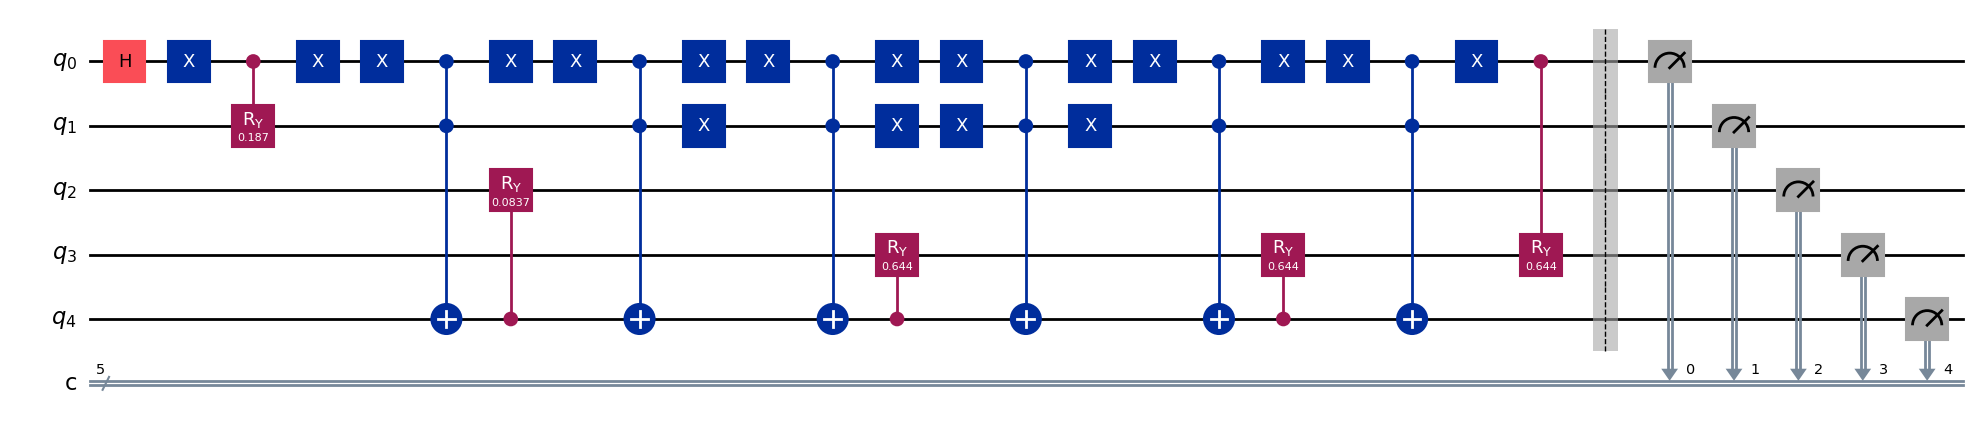

In [5]:
# --- Visualize the circuit using Matplotlib (mpl) backend ---
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

# Draw and display the full circuit
qc.draw(output='mpl', fold=-1, scale=1.0, filename="cables_event_tree_mpl.png")


In [51]:
!pip install pylatexenc    #restart the session after installing